# 

In [1]:
import os
import sys
import gc
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from dataclasses import dataclass

import bayes3d as b3d

need_pytorch3d=False
try:
    import pytorch3d as pt3d
except ModuleNotFoundError:
    need_pytorch3d=True

In [2]:
need_pytorch3d

False

In [3]:
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [4]:
torch.cuda.is_available()

True

In [5]:
import pytorch3d as pt3d
from pytorch3d.io import IO, load_objs_as_meshes
from pytorch3d.structures import Meshes
import pytorch3d.transforms as transforms
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftSilhouetteShader,
)

In [6]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

pt3dio = IO()

In [7]:
b3d.utils.get_assets_dir()

'/home/matin/bayes3d/assets'

In [8]:
def scale_and_center(mesh, scale=None):
    verts = mesh.verts_packed()
    center = verts.mean(0)
    if scale is None:
        scale = max((verts - center).abs().max(0)[0])
    mesh.offset_verts_(-center)
    mesh.scale_verts_((1.0 / float(scale)))

In [9]:
def extent(mesh):
    verts = mesh.verts_packed()
    return verts.max(0).values -  verts.min(0).values

In [10]:
model_dir = b3d.utils.get_assets_dir() + '/bop/ycbv/models'
mug_mesh = pt3dio.load_mesh(model_dir + '/obj_000014.ply', include_textures=False, device=device)
cube_mesh = load_objs_as_meshes([b3d.utils.get_assets_dir() + '/sample_objs/cube.obj'], load_textures=False, device=device)

scale_and_center(mug_mesh, scale=1e2)
scale_and_center(cube_mesh, scale=10000)

In [11]:
@dataclass
class SE3:
    rot: torch.Tensor
    tra: torch.Tensor

    def __mul__(self, other):
        new_rot = torch.matmul(self.rot, other.rot)
        new_tra = self.tra + torch.matmul(self.rot, other.tra)
        return SE3(new_rot, new_tra)

    def inv(self):
        rinv = torch.inverse(self.rot)
        return SE3(rinv, -torch.matmul(rinv, self.tra))

    def conj(self, other):
        return other.inv() * self * other

In [12]:
DIST = 2.7
ELEV = 0.0 # 30
AZIM = 0.0 
def get_scene_transforms(obj_transforms):
    R_0, T_0 = look_at_view_transform(dist=DIST, elev=ELEV, azim=AZIM)
    cam_tr = SE3(R_0[0, ...].to(dtype=torch.float64), T_0[0, ...].to(dtype=torch.float64))
    obj_tr = SE3(torch.from_numpy(np.eye(3)), torch.from_numpy(np.zeros(3)))
    for new_tr in obj_transforms:
        #obj_tr, cam_tr = new_tr * obj_tr, cam_tr * new_tr.conj(obj_tr)
        obj_tr, cam_tr = obj_tr * new_tr, cam_tr * new_tr
    return cam_tr.rot[None, ...], cam_tr.tra[None, ...]

In [13]:
# _obj_transforms = [ # left-handed around y
#     SE3(torch.from_numpy(np.eye(3)), torch.from_numpy(np.array([-0.2, 0.0, 0.3]))),
#     SE3(transforms.axis_angle_to_matrix(torch.from_numpy(-torch.pi/2 * np.array([1.0, 0.0, 0.0]))),
#         torch.from_numpy(np.array([0.0, 0.0, 0.0]))),
#     SE3(transforms.axis_angle_to_matrix(torch.from_numpy(torch.pi/3 * np.array([0.0, 0.0, 1.0]))),
#         torch.from_numpy(np.array([0.0, 0.0, 0.0]))),
#     #SE3(transforms.axis_angle_to_matrix(torch.from_numpy(-torch.pi/2 * np.array([1.0, 0.0, 0.0]))),
#         #torch.from_numpy(np.array([0.0, 0.0, 0.0]))),
#     #SE3(torch.from_numpy(np.eye(3)), torch.from_numpy(np.array([0.0, 0.5, 0.0]))),
# ]

In [14]:
IMG_SIZE = 100
def render_images(dists, elevs, azims): #dx, dy, theta):
    batch_size = 1 if dists.shape == torch.Size([]) else dists.shape[0]
    R, T = look_at_view_transform(dist=dists, elev=elevs, azim=azims, degrees=False)
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
    raster_settings = RasterizationSettings(image_size=IMG_SIZE, blur_radius=0.0, faces_per_pixel=1, bin_size=0)
    rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)
    return rasterizer(mug_mesh.extend(batch_size), eps=1e-8).zbuf

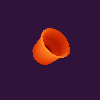

In [31]:
img0 = render_images(torch.tensor([2.7]),
                    torch.tensor([100]),
                    torch.tensor([100.0]))
b3d.viz.get_depth_image(img.reshape(IMG_SIZE, IMG_SIZE).cpu().numpy())

In [16]:
DIST_MEAN = 2.7
DIST_STD  = 2.0
ELEV_MEAN = torch.pi
ELEV_STD  = torch.pi/2
AZIM_MEAN = torch.pi
AZIM_STD  = torch.pi/2
def generate_images(n):
    z1, z2, z3 = torch.randn(3, n, device=device)
    dists = DIST_MEAN + DIST_STD * z1
    elevs = ELEV_MEAN + ELEV_STD * z2
    azims = AZIM_MEAN + AZIM_STD * z3
    return render_images(dists, elevs, azims)

In [73]:
img0 = render_images(torch.tensor([2.7]),
                    torch.tensor([100]),
                    torch.tensor([100.0]))

parameters = torch.tensor([2.1, 99.0, 98.0], requires_grad=True, device=device)

In [74]:
optimizer = torch.optim.Adam([parameters], betas=(0.9, 0.999), lr=1e-2)

In [75]:
img1 = render_images(parameters[0], parameters[1], parameters[2])

In [76]:
loss = (img1 - img0).pow(2).sum()
losses = []

In [77]:
for _ in tqdm(range(100)):
    optimizer.zero_grad()
    img1 = render_images(parameters[0], parameters[1], parameters[2])
    loss = (img1 - img0).pow(2).sum()
    loss.backward()
    losses.append(loss.item())
    optimizer.step()

  0%|          | 0/100 [00:00<?, ?it/s]

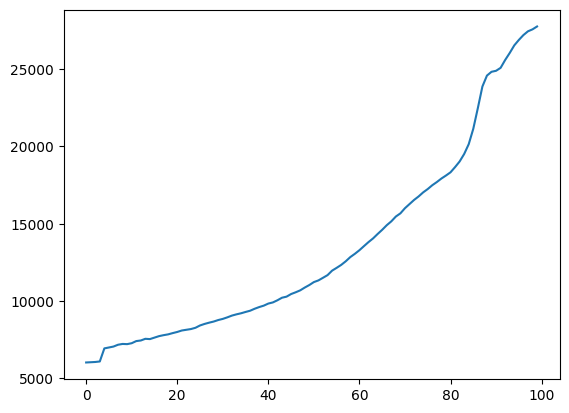

In [78]:
plt.plot(losses)

In [79]:
parameters

tensor([ 0.7385, 97.9504, 97.9485], device='cuda:0', requires_grad=True)

In [17]:
#b3d.viz.get_depth_image(generate_images(100).reshape(IMG_SIZE, IMG_SIZE).cpu().numpy())

# VAE Inference

In [18]:
import torch.nn as nn
from torch.optim import Adam
from torch import autograd

In [19]:
class Decoder(nn.Module):
    def __init__(self, std: float):
        super(Decoder, self).__init__()
        self.std = std
        
    def forward(self, dists_normalized, elevs_normalized, azims_normalized):
        dists = DIST_MEAN + DIST_STD * dists_normalized
        elevs = ELEV_MEAN + ELEV_STD * elevs_normalized
        azims = AZIM_MEAN + AZIM_STD * azims_normalized
        n_batches = dists.shape[0]
        noiseless_img = render_images(dists, elevs, azims)
        #noise = std * torch.randn_like(noiseless_img, device=device)
        return noiseless_img.reshape(n_batches, 1, IMG_SIZE, IMG_SIZE)
        
    def log_likelihood(self, gt_imgs, recon_imgs):
        noises = recon_imgs - gt_imgs
        pixelwise_dist = torch.distributions.normal.Normal(loc=0, scale=self.std)
        return pixelwise_dist.log_prob(noises).sum(axis=(1, 2, 3))

In [20]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=10, stride=3)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2)
        self.linear1 = nn.Linear(1152, 1024)
        self.linear2 = nn.Linear(1024, 1024)
        self.linear3 = nn.Linear(1024, 576)
        self.linear4 = nn.Linear(576, 192)
        self.linear5 = nn.Linear(192, 24)
        self.linear6 = nn.Linear(24, 6)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, imgs):
        x = self.conv1(imgs)
        x = self.relu(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        
        x = self.linear1(x.reshape(imgs.shape[0], -1))
        x = self.relu(x)
        
        x = self.linear2(x)
        x = self.relu(x)
        
        x = self.linear3(x)
        x = self.relu(x)

        x = self.linear4(x)
        x = self.relu(x)

        x = self.linear5(x)
        x = self.relu(x)

        x = self.linear6(x)
        unconstrained_means, unconstrained_logstds = x[:, :3], x[:, 3:]
        means = -1e2 + 2e2 * self.sigmoid(unconstrained_means)
        logstds = -5 + 10 * self.sigmoid(unconstrained_logstds)
        return torch.cat((means, logstds), axis=1)

In [21]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def sample_scene_params(self, latentss):
        batch_size = latentss.shape[0]
        meanss, log_stdss = latentss[:, :3], latentss[:, 3:]
        z1, z2, z3 = torch.randn(3, batch_size, device=device)
        dists_normalized = meanss[:, 0] + torch.exp(log_stdss[:, 0])*z1
        elevs_normalized = meanss[:, 1] + torch.exp(log_stdss[:, 1])*z2
        azims_normalized = meanss[:, 2] + torch.exp(log_stdss[:, 2])*z3
        return dists_normalized, elevs_normalized, azims_normalized
 
    def forward(self, imgs):
        latentss = self.encoder(imgs)
        dists_normalized, elevs_normalized, azims_normalized = self.sample_scene_params(latentss)
        reconstructions = self.decoder(dists_normalized, elevs_normalized, azims_normalized)
        return reconstructions, latentss

In [22]:
def gaussian_kl(mean, logstd): # KL(N(mean, std**2) || N(0, 1))
    logvar = 2*logstd
    # off by a mulitplicative 1/2 and additive -1/2 but doesn't matter
    return torch.exp(logvar) - logvar + mean.pow(2)

In [23]:
gnll = nn.GaussianNLLLoss()
def loss_fn(std, gt_imgs, recon_imgs, latentss):
    #torch.norm(gt_imgs - recon_imgs)#-vae.decoder.log_likelihood(gt_imgs, recon_imgs)
    #recon_loss = nn.functional.gaussian_nll_loss(gt_imgs, recon_imgs, std**2 + torch.zeros_like(gt_imgs))
    recon_loss =  gnll(recon_imgs, gt_imgs, std**2 + torch.zeros_like(gt_imgs))
    means, logstds = latentss[:, :3], latentss[:, 3:]
    prior_loss = gaussian_kl(means, logstds).sum()
    return (recon_loss + prior_loss).sum()

In [24]:
N = 30000

In [25]:
# gc.collect()
# sub_datasets = []
# for _ in range(N // 500):
#     sub_datasets.append(generate_images(500))
#     print('.', end='')
# silly_dataset = torch.cat(sub_datasets)
# silly_dataset = silly_dataset.reshape([N, 1, 100, 100])
# torch.save(silly_dataset, 'data.pt')

In [26]:
silly_dataset = torch.load('data.pt')

In [27]:
LOSS_STD = 0.05
vae = VAE(Encoder(), Decoder(std=LOSS_STD)).to(device)

In [28]:
optimizer = torch.optim.SGD(vae.parameters(), lr=1e-1)

In [29]:
BATCH_SIZE = 1000
assert N % BATCH_SIZE == 0
n_batches = N // BATCH_SIZE

In [30]:
losses = []
vae.train()

for epoch in range(10):
    overall_loss = 0

    batch_perm = np.random.permutation(N)
    print(f'epoch {epoch}:')

    for batch_idx in range(1, n_batches+1):
        batch_slice = batch_perm[(batch_idx-1)*BATCH_SIZE:batch_idx*BATCH_SIZE]
        batch = silly_dataset[batch_slice, :, :, :]

        optimizer.zero_grad()
    
        reconstructions, latentss = vae(batch)
        loss = loss_fn(LOSS_STD, batch, reconstructions, latentss)
        loss_val = loss.item()
        print(f'\tbatch {batch_idx} loss: {loss_val}')
        overall_loss += loss_val

        loss.backward()
        optimizer.step()

    losses.append(overall_loss / BATCH_SIZE)
    
    print(f'\tepoch complete! average Loss: {losses[-1]}')

epoch 0:
	batch 1 loss: 133954.65625
	batch 2 loss: 52036728.0
	batch 3 loss: 52036724.0
	batch 4 loss: 52036732.0
	batch 5 loss: 52036724.0
	batch 6 loss: 52036728.0
	batch 7 loss: 52036724.0
	batch 8 loss: 52036724.0
	batch 9 loss: 52036728.0
	batch 10 loss: 52036724.0
	batch 11 loss: 52036720.0
	batch 12 loss: 52036720.0
	batch 13 loss: 52036728.0
	batch 14 loss: 52036716.0
	batch 15 loss: 52036728.0
	batch 16 loss: 52036724.0
	batch 17 loss: 52036720.0
	batch 18 loss: 52036716.0
	batch 19 loss: 52036720.0
	batch 20 loss: 52036728.0
	batch 21 loss: 52036720.0
	batch 22 loss: 52036712.0
	batch 23 loss: 52036728.0
	batch 24 loss: 52036724.0
	batch 25 loss: 52036728.0
	batch 26 loss: 52036716.0
	batch 27 loss: 52036720.0
	batch 28 loss: 52036724.0
	batch 29 loss: 52036720.0
	batch 30 loss: 52036720.0
	epoch complete! average Loss: 1509198.92265625
epoch 1:
	batch 1 loss: 52036724.0
	batch 2 loss: 52036724.0
	batch 3 loss: 52036724.0
	batch 4 loss: 52036724.0
	batch 5 loss: 52036720.0
	


KeyboardInterrupt



In [ ]:
vae.encoder.linear1.grad

In [ ]:
plt.plot(losses)

# 

# 